In [11]:
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import models, layers
from tensorflow.keras import optimizers, losses, metrics
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data loading
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# Data normalization
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [3]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))  # shape[1] = len(input_col)
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # No activation function (linear)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

Processing Fold # 0
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-16 10:17:41.369305: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-16 10:17:41.369607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-04-16 10:17:41.605698: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-16 10:17:41.768821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-16 10:17:43.420347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Processing Fold # 1


2023-04-16 10:30:36.609114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-16 10:30:38.233413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Processing Fold # 2


2023-04-16 10:43:39.058771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-16 10:43:40.611950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Processing Fold # 3


2023-04-16 10:56:43.377953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-16 10:56:44.971090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


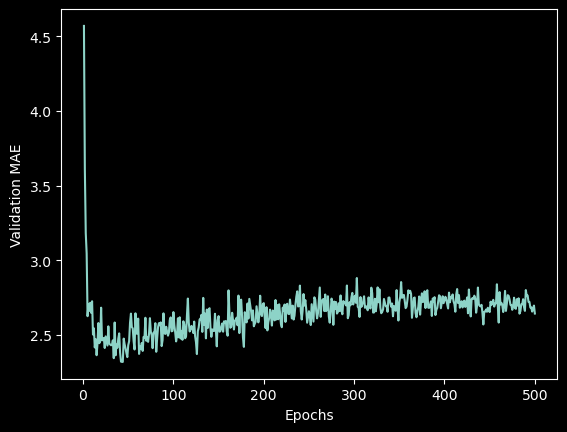

In [4]:
# Main loop
k = 4
num_val_samples = len(train_data)//k    # floor division
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('Processing Fold #', i)
    # Preparing validation data for kth fold
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]

    # Concatenate the training dataset for kth fold
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data = (val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    # Collecting the validation errors
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

# averaging the mae history
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

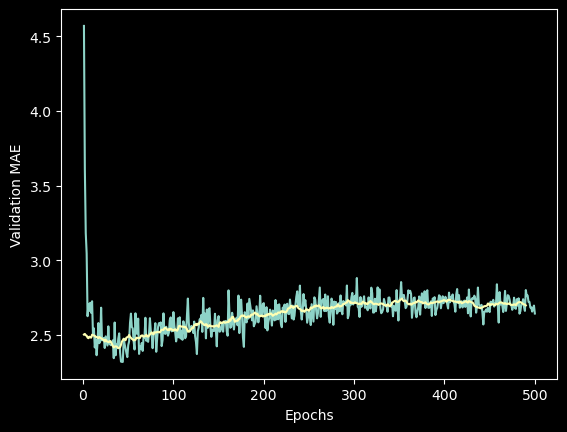

In [9]:
# Smooth curve
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

# visualization
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [6]:
# Final model
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

2023-04-16 11:09:40.048715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 12ms/step - loss: 19.7804 - mae: 2.7733


2023-04-16 11:09:52.858793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [12]:
## Pickle examples
import pickle

# saving file
with open('chapter3_6_history', 'wb') as f:
    pickle.dump(history.history, f)

# loading file
with open('chapter3_6_history', 'rb') as f:
    h_loaded = pickle.load(f)

# # Another method 
# saving file
# f = open('chapter3_6_history', 'wb')
# pickle.dump(history.history, f)
# f.close()

# loading file
# f = open('chapter3_6_history', 'rb')
# h_loaded = pickle.load(f)
# f.close()